#**Теория вероятностей и математическая статистика**
##Курсовая работа


Исследовать корреляционную зависимость и выявить методами парной регрессии зависимость для динамической вязкости нефтяной эмульсии от обводненности при различных плотностях нефти и различных значениях температуры и давления для различных степеней деспергирования нефти в воде или воды в нефти. Исследовать инверсию фаз.

Для исследования желательно следующие данные:

* вязкость эмульсии
* обводненность эмульсии
* плотность нефти
* плотность воды
* вязкость воды
* вязкость чистой нефти
* температура эмульсии
* давление при котором происходить измерение
* размер зерна несомой фазы (воды в нефти или нефти в воде)

Данные подготовлены по работе Miss Sarin Wutthisirisart "ANALYSIS OF VISCOSITY OF LIGHT OIL AND ITSEMULSION FROM AN OILFIELD IN THAILAND", Chulalongkorn University, 2014.


Заданы следующие параметры:

* плотность нефти $828  \dfrac{kg}{m^3}$
*дисперсность не определена, предполагается, что она постоянная для всех экспериментов.

Остальные параметры предполагается соответствуют нормальным условиям.

## Используемые библиотеки

In [1]:
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from google.colab import files
from statsmodels.stats.diagnostic import lilliefors
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Вспомогательные функции

In [2]:
def emissions(data):
    # Считаем диапазон за границами которого все выброс.    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

In [3]:
def pair_regression(x, y):
    # Решаем методом парной регрессии.    
    b1 = np.cov(x, y, ddof=1)[0, 1] / np.var(x, ddof=1)
    return (y.mean() - b1 * x.mean(), b1)

In [4]:
def regression_plot(x, y, b0, b1, xlabel, ylabel, show_scatter=True):
    # Отрисовали графики по методу парной регрессии.    
    ox = np.array(sorted(list(set(x))))
    # восстановили y, так как ранее логарифмировали переменную y.
    oy = np.exp(b0 + b1 * ox)

    if (show_scatter):
        plt.scatter(x, y)
    plt.plot(ox, oy, color='red', alpha=0.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

In [5]:
def least_square_method(x, y):
    # Метод наименьших квадратов.
    XTX = x.T.dot(x)
    XTX_inv = np.linalg.inv(XTX)
    return XTX_inv.dot(x.T).dot(y)

# Загружаем данные

In [6]:
file = files.upload()

Saving ds_001.csv to ds_001.csv


In [7]:
!ls

ds_001.csv  sample_data


In [8]:
df = pd.read_csv('ds_001.csv', encoding='UTF-8')

In [10]:
df.head()

,watercut,temperature,angularvelocity,viscosity
0,0,30,1,29192.100
1,0,30,5,84660.000
2,0,30,15,3557.889
3,0,30,25,1886.586
4,0,30,35,1371.674


Здесь:

* watercut – обводненность в долях %;
* temperature – температура, °C;
* angularvelocity – угловая скорость измерительного цилиндра вискозиметра, об/мин;
* viscosity – динамическая вязкость водонефтяной эмульсии, сП;

# **Первичная обработка данных**

# Сортируем

In [11]:
df = df.sort_values(by=['viscosity'])

Посмотрели статистику

In [12]:
df.describe()

,watercut,temperature,angularvelocity,viscosity
count,252.000000,252.000000,252.000000,243.000000
mean,30.000000,56.666667,23.500000,1786.347825
std,20.039801,19.759510,19.987546,8022.352488
min,0.000000,30.000000,1.000000,1.200000
25%,10.000000,40.000000,5.000000,4.649400
50%,30.000000,55.000000,20.000000,6.366700
75%,50.000000,70.000000,35.000000,22.375350
max,60.000000,90.000000,60.000000,84660.000000


In [13]:
df.head(8)

,watercut,temperature,angularvelocity,viscosity
246,60,90,1,1.2000
210,50,90,1,1.2365
247,60,90,5,1.2540
211,50,90,5,1.4613
248,60,90,15,1.5268
240,60,70,1,1.5600
249,60,90,25,1.5794
250,60,90,35,1.6547


In [14]:
df.tail(8)

,watercut,temperature,angularvelocity,viscosity
11,0,40,60,NaN
46,10,40,35,NaN
47,10,40,60,NaN
82,20,40,35,NaN
83,20,40,60,NaN
118,30,40,35,NaN
119,30,40,60,NaN
155,40,40,60,NaN


Информация о данных

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 246 to 155
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   watercut         252 non-null    int64  
 1   temperature      252 non-null    int64  
 2   angularvelocity  252 non-null    int64  
 3   viscosity        243 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 9.8 KB


**Есть пустые значения, удалим их из выборки**

In [16]:
len(df) - df.count()

watercut           0
temperature        0
angularvelocity    0
viscosity          9
dtype: int64

In [17]:
df = df.dropna()

In [18]:
len(df) - df.count()

watercut           0
temperature        0
angularvelocity    0
viscosity          0
dtype: int64

**Есть очень большие значения, которые либо не сильно влияют на выборку, либо являются выбросами**

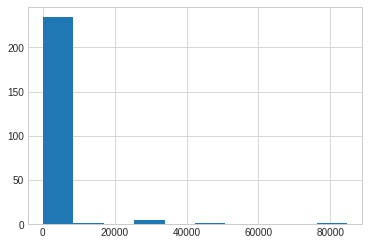

In [20]:
df['viscosity'].hist();

**Данные слишком ассиметричны, поэтому прологарифмируем вязкость**

In [21]:
df['viscosity_log'] = np.log(df['viscosity'])

In [22]:
df.describe()

,watercut,temperature,angularvelocity,viscosity,viscosity_log
count,243.000000,243.000000,243.000000,243.000000,243.000000
mean,30.452675,57.283951,22.559671,1786.347825,2.986229
std,20.108200,19.855616,19.589790,8022.352488,2.612025
min,0.000000,30.000000,1.000000,1.200000,0.182322
25%,10.000000,40.000000,5.000000,4.649400,1.536738
50%,30.000000,60.000000,15.000000,6.366700,1.851081
75%,50.000000,70.000000,35.000000,22.375350,3.107958
max,60.000000,90.000000,60.000000,84660.000000,11.346399


**Посчитаем выбросы**

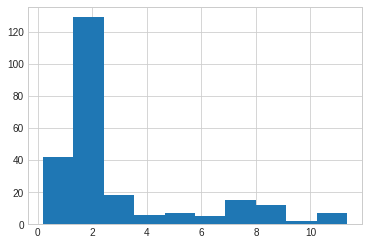

In [23]:
df['viscosity_log'].hist();

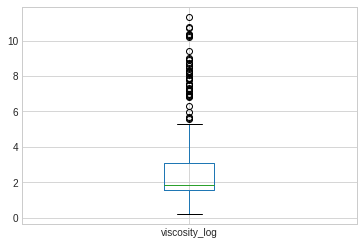

In [24]:
df[['viscosity_log']].boxplot();

**Как видно выбросы располагаются в области больших значений**

**Удаляем лишнее**

In [25]:
r_1, r_2 = emissions(df['viscosity_log'])
(r_1, r_2)

(-0.8200916294713674, 5.464787755588469)

In [26]:
df = df.loc[(r_1 < df['viscosity_log']) & (df['viscosity_log'] < r_2)]

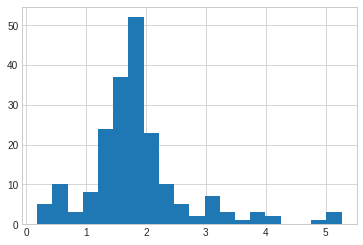

In [27]:
df['viscosity_log'].hist(bins=20);

In [28]:
df.describe()

,watercut,temperature,angularvelocity,viscosity,viscosity_log
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,30.502513,63.216080,22.577889,11.471040,1.851991
std,20.219721,16.898644,19.487181,25.201753,0.853375
min,0.000000,40.000000,1.000000,1.200000,0.182322
25%,10.000000,50.000000,5.000000,4.295350,1.457515
50%,30.000000,60.000000,15.000000,5.891000,1.773426
75%,50.000000,70.000000,35.000000,8.109200,2.092999
max,60.000000,90.000000,60.000000,193.412000,5.264823


In [29]:
print((100/252)*199, '%')

78.96825396825396 %


**График вязкости**

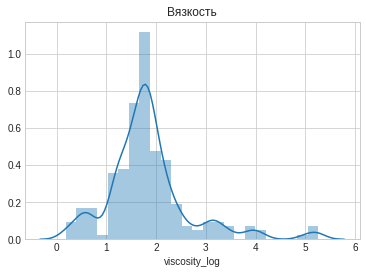

In [30]:
sns.distplot(df['viscosity_log'])
plt.title('Вязкость')
plt.show()

In [31]:
df.describe()

,watercut,temperature,angularvelocity,viscosity,viscosity_log
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,30.502513,63.216080,22.577889,11.471040,1.851991
std,20.219721,16.898644,19.487181,25.201753,0.853375
min,0.000000,40.000000,1.000000,1.200000,0.182322
25%,10.000000,50.000000,5.000000,4.295350,1.457515
50%,30.000000,60.000000,15.000000,5.891000,1.773426
75%,50.000000,70.000000,35.000000,8.109200,2.092999
max,60.000000,90.000000,60.000000,193.412000,5.264823


**Вполне приемлемо**

# Проведем корелляционный анализ

### **Рассмотрим корреляцию динамической вязкости водонефтяной эмульсии от обводнености, температуры и угловой скорости вращения вискозиметра**

## Пирсон

In [32]:
df[['watercut', 'temperature', 'angularvelocity', 'viscosity_log']].corr(method='pearson')

,watercut,temperature,angularvelocity,viscosity_log
watercut,1.000000,-0.034316,0.036302,-0.373060
temperature,-0.034316,1.000000,0.065337,-0.690215
angularvelocity,0.036302,0.065337,1.000000,-0.180820
viscosity_log,-0.373060,-0.690215,-0.180820,1.000000


## Кендал

In [33]:
df[['watercut', 'temperature', 'angularvelocity', 'viscosity_log']].corr(method='kendall')

,watercut,temperature,angularvelocity,viscosity_log
watercut,1.000000,-0.029323,0.028159,-0.340963
temperature,-0.029323,1.000000,0.046851,-0.625108
angularvelocity,0.028159,0.046851,1.000000,-0.093547
viscosity_log,-0.340963,-0.625108,-0.093547,1.000000


## Спирман

In [34]:
df[['watercut', 'temperature', 'angularvelocity', 'viscosity_log']].corr(method='spearman')

,watercut,temperature,angularvelocity,viscosity_log
watercut,1.000000,-0.037526,0.036346,-0.458701
temperature,-0.037526,1.000000,0.059334,-0.763955
angularvelocity,0.036346,0.059334,1.000000,-0.129203
viscosity_log,-0.458701,-0.763955,-0.129203,1.000000


**Видно, что вязкость достаточно сильно зависит от температуры, причем зависимость эта обратная, т.е. чем выше температура образца, тем меньше вязкость. Менее сильно зависит вязкость от обводненности и слабо зависит от начальной угловой скорости сдвига. Везде связь обратная.**

## Визуализируем

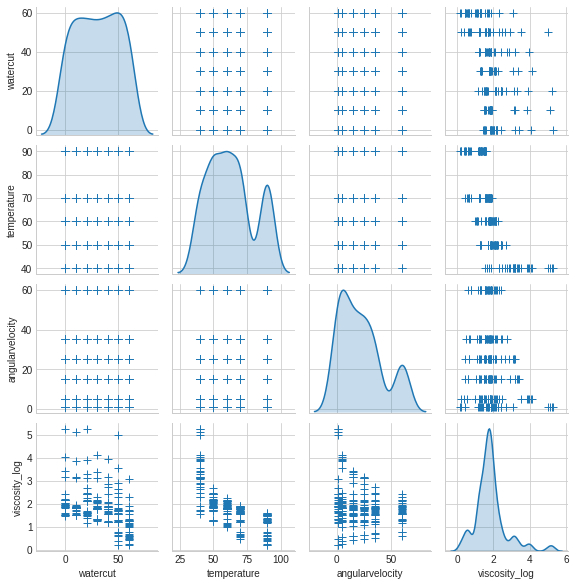

In [35]:
g = sns.pairplot(df[['watercut', 'temperature', 'angularvelocity', 'viscosity_log']], diag_kind="kde", markers="+",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True), height=2)

## Ковариации

In [36]:
np.cov(df['temperature'], df['viscosity_log'])

array([[285.56418456,  -9.95350719],
       [ -9.95350719,   0.72824814]])

In [37]:
np.cov(df['watercut'], df['viscosity_log'])

array([[408.83711487,  -6.4371498 ],
       [ -6.4371498 ,   0.72824814]])

In [38]:
np.cov(df['angularvelocity'], df['viscosity_log'])

array([[379.75021573,  -3.00700501],
       [ -3.00700501,   0.72824814]])

## Проведем проверку на нормальность

In [39]:
stats.kstest(df['viscosity_log'], 'norm')

KstestResult(statistic=0.7645949131524361, pvalue=3.961434375644388e-122)

In [40]:
stats.kstest(df['temperature'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [41]:
stats.kstest(df['watercut'], 'norm')

KstestResult(statistic=0.8592964824120604, pvalue=1.5133500746786172e-169)

In [42]:
stats.kstest(df['angularvelocity'], 'norm')

KstestResult(statistic=0.8413447460685429, pvalue=7.876876369036086e-159)

In [43]:
"Не нормально" if stats.kstest(df['viscosity_log'], 'norm').statistic < stats.ksone.ppf(0.95, n=df.shape[0]) else "Нормально"

'Нормально'

In [44]:
"Не нормально" if stats.kstest(df['temperature'], 'norm').statistic < stats.ksone.ppf(0.95, n=df.shape[0]) else "Нормально"

'Нормально'

In [45]:
"Не нормально" if stats.kstest(df['watercut'], 'norm').statistic < stats.ksone.ppf(0.95, n=df.shape[0]) else "Нормально"

'Нормально'

In [46]:
"Не нормально" if stats.kstest(df['angularvelocity'], 'norm').statistic < stats.ksone.ppf(0.95, n=df.shape[0]) else "Нормально"

'Нормально'

**Принимаем нормальность нашей выборки**

## Посчитаем парную регрессию

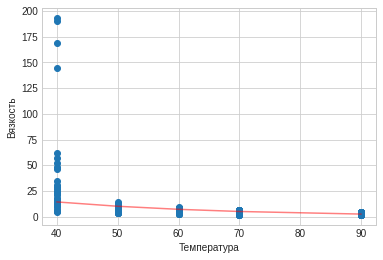

In [47]:
b0, b1 = pair_regression(df['temperature'], df['viscosity_log'])
regression_plot(df['temperature'], df['viscosity'], b0, b1, 'Температура', 'Вязкость')

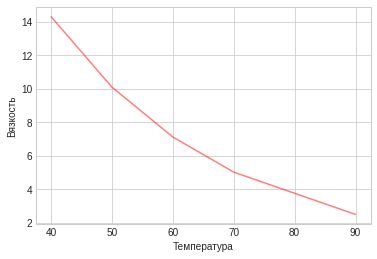

In [48]:
regression_plot(df['temperature'], df['viscosity'], b0, b1, 'Температура', 'Вязкость', False)

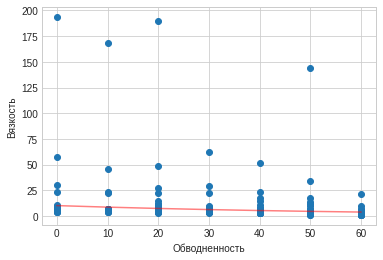

In [49]:
b0, b1 = pair_regression(df['watercut'], df['viscosity_log'])
regression_plot(df['watercut'], df['viscosity'], b0, b1, 'Обводненность', 'Вязкость')

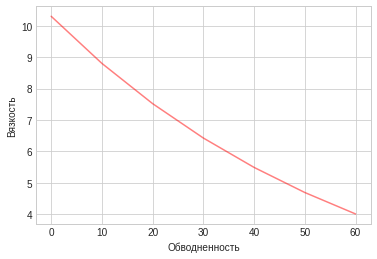

In [50]:
regression_plot(df['watercut'], df['viscosity'], b0, b1, 'Обводненность', 'Вязкость', False)

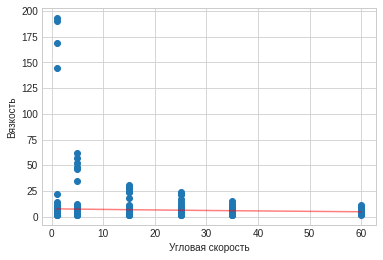

In [51]:
b0, b1 = pair_regression(df['angularvelocity'], df['viscosity_log'])
regression_plot(df['angularvelocity'], df['viscosity'], b0, b1, 'Угловая скорость', 'Вязкость')

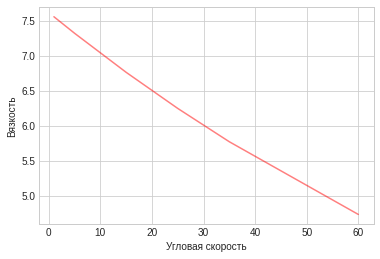

In [52]:
regression_plot(df['angularvelocity'], df['viscosity'], b0, b1, 'Угловая скорость', 'Вязкость', False)

In [53]:
np.corrcoef(df['temperature'], df['viscosity_log']) ** 2

array([[1.        , 0.47639715],
       [0.47639715, 1.        ]])

Коэффициент детерминации, равный 0.4764 , означает, что 48% дисперсии вязкости учитывается или объясняется моделью. Оставшиеся 52% обусловлены какими-то ещё факторами, которые модель не учла.

In [54]:
np.corrcoef(df['watercut'], df['viscosity_log']) ** 2

array([[1.        , 0.13917382],
       [0.13917382, 1.        ]])

Коэффициент детерминации, равный 0.1392 , означает, что 13% дисперсии вязкости учитывается или объясняется моделью. Оставшиеся 87% обусловлены какими-то ещё факторами, которые модель не учла.

In [55]:
np.corrcoef(df['angularvelocity'], df['viscosity_log']) ** 2

array([[1.        , 0.03269572],
       [0.03269572, 1.        ]])

Коэффициент детерминации, равный 0.0327 , означает, что 3% дисперсии вязкости учитывается или объясняется моделью. Оставшиеся 97% обусловлены какими-то ещё факторами, которые модель не учла. В дальнейшем этот фактор можно не учитвать.

**Как видно, парная регрессия не полностью объясняет дисперсию**

## Метод наименьших квадратов

In [56]:
x = df[['temperature', 'watercut']].values
y = df['viscosity_log'].values.reshape(-1, 1)

Добавим столбец единиц

In [57]:
x = np.hstack((np.ones((x.shape[0], 1)), x))

In [58]:
b = least_square_method(x, y)
b

array([[ 4.61029623],
       [-0.03554393],
       [-0.01676441]])

Модель регрессии имеет вид:$$y = 4,61029623 - 0,03554393 \cdot x_1 - 0,01676441 \cdot x_2,$$где $x_1$ — температура, $x_2$ — обводненность.

Проверим несмещенность модели

In [59]:
x.dot(b).mean(), y.mean()

(1.8519913680305569, 1.8519913680305529)

**Наша модель несмещенная**

## Оценим уравнение регрессии

In [60]:
z = x.dot(b)

print(f'real: {y[:6].T}')
print(f'pred: {z[:6].T}')

real: [[0.18232156 0.21228481 0.22633844 0.37932645 0.42317404 0.44468582]]
pred: [[0.40547751 0.57312161 0.40547751 0.57312161 0.40547751 1.11635621]]


In [61]:
R = 1 - (z - y).var() / y.var()
R

0.6339897155862436

In [62]:
z.var(), y.var()

(0.4593817186111686, 0.7245885971295051)

**Коэффициент детерминации для модели оказался лучше чем для парной регрессии, что вобщем-то неплохо.**

## Рассчитаем среднюю ошибку аппроксимации

In [63]:
np.abs((y - z) / y).mean()

0.21509591648964738

## Оценим значимость уравнения линейной регрессии

In [64]:
# Два фактора
k = 2
# Количество измерений
n = x.shape[0]
k1 = k
k2 = n - k - 1

F = (R / k1) / ((1 - R) / k2)
F

169.752039145479

In [65]:
F_crit = stats.f.ppf(0.95, k1, k2)
F_crit

3.0419902345156493

In [66]:
F > F_crit

True

Имеем F &gt; F_{crit}, поэтому уравнение регрессии статистически значимо.

## Отрисуем полученный результат

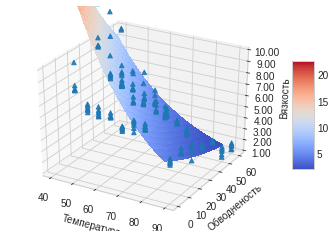

In [67]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax = fig.add_subplot(111, projection='3d')

# Посчитали.
X = np.arange(40, 90, 2.5)
Y = np.arange(0, 60, 3)
X, Y = np.meshgrid(X, Y)
Z = np.exp(4.61029623 - 0.03554393 * X - 0.01676441 * Y)

xs = np.array(df['temperature'].values)
ys = np.array(df['watercut'].values)
zs = np.array(df['viscosity'].values)

# Отрисовали.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(xs, ys, zs, marker='^')

# Настроили отображение.
ax.set_zlim(1, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('Температура')
ax.set_ylabel('Обводненость')
ax.set_zlabel('Вязкость')

# Добавили цветной градиент.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Полная модель регрессии имеет вид:$$\mu = e^{4,6103 - 0,0355 \cdot T - 0,0168 \cdot W}$$где $\mu$ — вязкость, $T$ — температура, $W$ — обводненность.